# RT2 Assignment 2

## HOW TO USE PROPERLY
- WARNING - SOMETIMES THERE ARE SOME BUGS REGARDING THE EXECUTION OF THE TASK. IF ROBOT DOESNT MOVE, ALTHOUGH IT CHANGED ITS STATE RESET THE SIMULATION AND RESTART THE KERNEL, RUN ALL CELLS AGAIN. This issue has something to do with the package meant for navigation, from what I noticed everything by my side works fine  ¯\_(ツ)_/¯

1. Launch the simulation by 'roslaunch rt_assignment_2 assignment_2.launch' in your workspace
   - Remember to catkin make package, and that it requires `assginment_2_2023` package alongside
2. Start the kernel and run all the cells, everything should run without issues.
3. The last cell provides UI - Have Fun!


Goals of this assignment:
- an interface to assign (or cancel) goals to the robot 
- a plot with the robot’s position and targets’ positions in the environment
- a plot for the number of reached/not-reached targets

Todo:
- add better layout, add output log to know what is happenning

In [1]:
import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

import rospy
from nav_msgs.msg import Odometry
from std_msgs.msg import Empty
from rt_assignment_2.msg import RobotTarget, RobotCancelGoal


%matplotlib widget

# Rosnode Init 

In [2]:
# This will block the rest of the code until master process is run
rospy.init_node('odom_visualizer_node')

# Publishers
pub_robot_target = rospy.Publisher('/robot_target', RobotTarget, queue_size=10)
pub_robot_cancel_goal = rospy.Publisher('/robot_cancel_goal', RobotCancelGoal, queue_size = 10);


## Visualiser class

Class for plots

In [3]:
class Visualiser:
    def __init__(self):
        self.fig, (self.ax1, self.ax2) = plt.subplots(1,2)
        self.ln, = self.ax1.plot([], [], 'ro', label = 'robot-path')
        self.x_pts, = self.ax1.plot([], [], 'x', label = 'targets')
        self.x_pos, self.y_pos = [] , []
        self.targets_x, self.targets_y = [], []

        # second plot
        self.bar_labels = ['non-reached', 'reached']
        self.bar_colors = ['tab:red', 'tab:green']
        self.targets_reached, self.targets = [] , []

        self.bar = self.ax2.bar(self.bar_labels, [0,0], label=self.bar_labels, color=self.bar_colors)
        

    def plot_init(self):
        self.ax1.set_title('Robot Arena')
        self.ax1.set_ylabel('y-dist [units]')
        self.ax1.set_xlabel('x-dist [units]')
        self.ax1.grid(True)
        self.ax1.set_xlim(10, -10)
        self.ax1.set_ylim(10, -10)
        self.ax1.legend()

        self.ax2.set_title('Target types')
        self.ax2.set_ylim(0, 10)
        self.ax2.set_yticks(range(11))
        self.ax2.set_ylabel('number of targets')
        
        
        return self.ln,

    def add_target_update_plot(self, x, y):
        self.targets_x.append(x)
        self.targets_y.append(y)
        self.targets.append((x,y))
        self.x_pts.set_data(self.targets_x, self.targets_y)
        self.ax1.text(self.targets_x[-1] - 0.4, self.targets_y[-1] + 0.4, f't_{len(self.targets_x)}')
        self.update_second_plot()

    
    def odom_callback(self, msg):
        self.y_pos.append(msg.pose.pose.position.y)
        self.x_pos.append(msg.pose.pose.position.x)

    def update_plot(self, frame):
        self.ln.set_data(self.x_pos, self.y_pos)
        return self.ln,

    def mark_target_reached_and_update_plot(self):
        self.targets_reached.append(self.targets[-1])
        self.update_second_plot()

    def update_second_plot(self):
        self.bar[0].set_height(len(self.targets) - len(self.targets_reached))
        self.bar[1].set_height(len(self.targets_reached))


# Widget Setup
The block below also includes callbacks

In [4]:
def setup_floatText(str):
    widget = widgets.FloatText(
        value=0.0,
        description=str,
        disabled = False
        )
    return widget

def setup_button(name, icon, style = ''):
    button = widgets.Button(
            value=False,
            description=name,
            disabled=False,
            button_style=style, # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Description',
            icon=icon# (FontAwesome names without the `fa-` prefix)
        )
    return button

# Callbacks
def send_target(click):
    #create message
    msg_robotTarget = RobotTarget()
    msg_robotTarget.x = x_widget.value
    msg_robotTarget.y = y_widget.value
    # update target plot
    vis.add_target_update_plot(msg_robotTarget.x, msg_robotTarget.y)
    # Publish the message
    pub_robot_target.publish(msg_robotTarget)
    print(f'Message sent:')
    return

def cancel_goal(b_cancel_goal):
    pub_robot_cancel_goal.publish(RobotCancelGoal())
    print('current Goal is cancelled')
    return

def is_goal_reached_callback(data):
    vis.mark_target_reached_and_update_plot()


# setup widgets
x_widget = setup_floatText('x: ')
y_widget = setup_floatText('y: ')

b_set_target = setup_button('Send new target', 'paper-plane')
b_set_target.on_click(send_target)

b_cancel_goal = setup_button('Cancel current Goal', 'paper-plane', 'warning')
b_cancel_goal.on_click(cancel_goal)

# buttons in layout
widgets_layout = TwoByTwoLayout(top_left=x_widget,
                                top_right=b_set_target,
                                bottom_left=y_widget,
                                bottom_right=b_cancel_goal);

## Turn it on

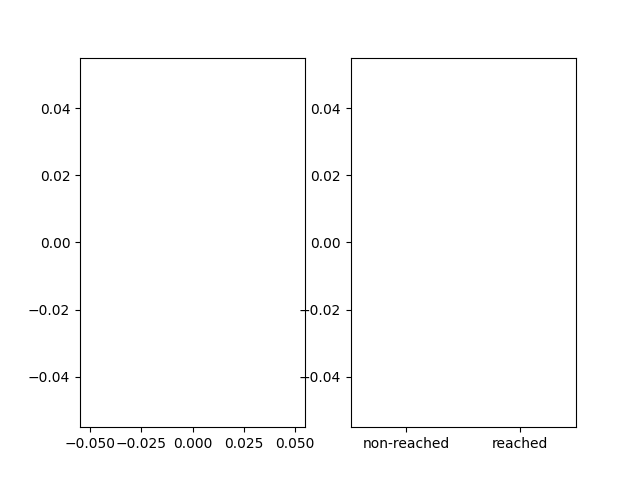

TwoByTwoLayout(children=(FloatText(value=0.0, description='x: ', layout=Layout(grid_area='top-left')), Button(…

In [5]:
vis = Visualiser();

#Subscribers
sub_odom = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
sub_goal_is_reached = rospy.Subscriber("/goal_is_reached",
                                       Empty, is_goal_reached_callback)

ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init, save_count = 20)
plt.show(block=True)

widgets_layout